## 1. Downloading Dataset and KerasCV

In [ ]:
!curl -s -L 'https://universe.roboflow.com/ds/1i3gXGrY97?key=SkyD74ZzLp' > roboflow.zip; unzip -o -qq roboflow.zip; rm roboflow.zip

In [ ]:
!pip install tensorflow
!pip install keras_cv
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.4 MB/s eta 0:00:00


## 2. Data Preprocessing

### 2.1 Environment Setup and Imports

In [ ]:
import math
import os
from tensorflow.keras import layers
import keras_cv, keras
import tensorflow as tf
import json, os
import random

os.environ['KERAS_BACKEND'] = 'jax'  # @param ['tensorflow', 'jax', 'torch']

# Dataset splits

splits = {
    'train': '/content/train',
    'test': '/content/test',
    'validation': '/content/valid'
}

BATCH_SIZE = 4
TARGET_IMAGE_SIZE = 256

Using TensorFlow backend


### 2.2 Augmentation Layers

In [ ]:
augmentation_layers = tf.keras.Sequential([
  layers.Rescaling(1./255),  # Normalize images to 0-1 range
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomZoom(0.2),
  layers.Resizing(TARGET_IMAGE_SIZE,TARGET_IMAGE_SIZE, interpolation="bilinear",crop_to_aspect_ratio=False)
])

def augment(ds, batch_size=BATCH_SIZE, shuffle_buffer_size=1000):
    if ds == train_ds:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.batch(batch_size)

    if ds == train_ds:
        ds = ds.map(lambda x, y: (augmentation_layers(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

### 2.3 Preprocessing Functions

In [ ]:
def merge_humerus_annotations(split_path):
    """
    Corrects the labels in the annotations file by changing 'humerus' to 'humerus fracture'.

    Args:
    split_path (str): The file path of the split (train, test, or validation) to correct annotations.
    """

    annotations_path = os.path.join(split_path, '_annotations.createml.json')

    with open(annotations_path, 'r') as file:
        annotations = json.load(file)

    for entry in annotations:
        for annotation in entry['annotations']:
            if annotation['label'] == 'humerus':
                annotation['label'] = 'humerus fracture'

    with open(annotations_path, 'w') as file:
        json.dump(annotations, file, indent=4)

def load_image(filepath, target_image_size=(256, 256)):
    """
    Loads an image from a specified file path, resizes it, and returns it as a TensorFlow tensor.

    Args:
        filepath (str): The path to the image file to be loaded.
        target_image_size (tuple, optional): The target size for resizing the image. Defaults to (224, 224).

    Returns:
        tf.Tensor: A resized 3-channel RGB image as a TensorFlow tensor with data type `tf.float32`.
    """

    image_data = tf.io.read_file(filepath)
    image = tf.cast(tf.io.decode_jpeg(image_data, channels=3), tf.float32)

    # Resize the image to the target size
    image = tf.image.resize(image, target_image_size)

    return image

### 2.4 Generating Datasets

In [ ]:
for split_path in splits.values():
    merge_humerus_annotations(split_path)

class_mapping = {
    0: 'elbow positive',
    1: 'fingers positive',
    2: 'forearm fracture',
    3: 'humerus fracture',
    4: 'shoulder fracture',
    5: 'wrist positive',
    6: 'none'
}

label_to_id = {v: k for k, v in class_mapping.items()} # Inverse mapping

def load(split, keep_prob=0.33):
    """
    Loads images and labels into a TensorFlow Dataset.

    Args:
    split (str): The file path of the split (train, test, or validation)
    keep_prob (float): The Probability to add a 'none' class to the final dataset (reduces overfitting)

    Returns:
    tf.data.Dataset: The resulting TensorFlow Dataset.
    """

    annotations_path = os.path.join(splits[split], '_annotations.createml.json')
    with open(annotations_path) as f:
        annotations_file = json.load(f)

    annotated_images = {entry['image']: entry['annotations'][0]['label'] for entry in annotations_file if entry['annotations']}

    all_image_files = os.listdir(splits[split])
    all_image_files = [file for file in all_image_files if not file.endswith('.json')]

    def generator():
        for image_file in all_image_files:
            if image_file.endswith((".jpg", ".jpeg", ".png")):
                image_path = os.path.join(splits[split], image_file)
                image = load_image(image_path)

                if image_file in annotated_images:
                    class_label = annotated_images[image_file]
                else:
                    class_label = 'none'

                # Skip 'none' class samples based on keep_prob
                if class_label == 'none' and random.random() > keep_prob:
                    continue

                class_id = label_to_id[class_label]
                one_hot_label = tf.one_hot(class_id, depth=len(class_mapping))

                yield image, one_hot_label

    return tf.data.Dataset.from_generator(generator, output_signature=(
        tf.TensorSpec(shape=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE, 3), dtype=tf.float32),  # Adjusted shape to fixed size
        tf.TensorSpec(shape=(len(class_mapping),), dtype=tf.float32)))

train_ds = load('train')
val_ds = load('validation')
test_ds = load('test')

TRAIN_SIZE = sum(1 for _ in train_ds)
VAL_SIZE = 348

TRAIN_STEPS = math.floor((TRAIN_SIZE / BATCH_SIZE)) # Calculating steps per epoch to train
VAL_STEPS = math.floor((VAL_SIZE / BATCH_SIZE))

## 3. Augmentation

In [ ]:
train_ds = augment(train_ds, BATCH_SIZE).repeat()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).repeat()
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## 4. Model

### 4.1 Defining Model

100%|██████████| 1.79k/1.79k [00:00<00:00, 1.54MB/s]
100%|██████████| 78.6M/78.6M [00:05<00:00, 15.1MB/s]
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


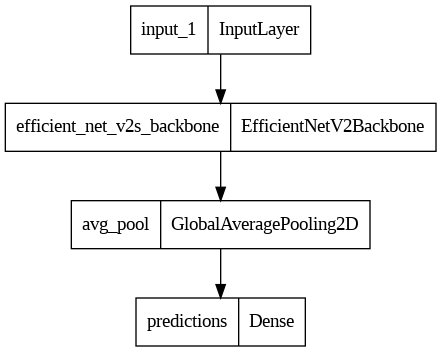

In [ ]:
from keras import optimizers

MODEL = 'efficientnetv2_s_imagenet' # EfficientNetV2

backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    MODEL
)

model = keras_cv.models.ImageClassifier(
    backbone=backbone,
    num_classes=7,
    activation='softmax',
)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(learning_rate=1.5e-5),
    metrics=['accuracy']
)

tf.keras.utils.plot_model(
    model,
    to_file='model.png',
)

### 4.2 Training Model

In [ ]:
EPOCHS = 25

# Saving best model during training
checkpoint_filepath = '/content/best.weights.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    initial_value_threshold=0.7)

# Training model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback],
    steps_per_epoch = TRAIN_STEPS,
    validation_steps = VAL_STEPS
)

Epoch 1/25
598/598 [==============================] - 177s 141ms/step - loss: 1.9006 - accuracy: 0.2421 - val_loss: 1.8186 - val_accuracy: 0.3478
Epoch 2/25
598/598 [==============================] - 84s 141ms/step - loss: 1.7262 - accuracy: 0.3730 - val_loss: 1.6191 - val_accuracy: 0.4162
Epoch 3/25
598/598 [==============================] - 86s 144ms/step - loss: 1.5282 - accuracy: 0.4626 - val_loss: 1.3682 - val_accuracy: 0.4885
Epoch 4/25
598/598 [==============================] - 84s 140ms/step - loss: 1.3447 - accuracy: 0.5199 - val_loss: 1.2145 - val_accuracy: 0.5520
Epoch 5/25
598/598 [==============================] - 85s 142ms/step - loss: 1.2022 - accuracy: 0.5609 - val_loss: 1.0353 - val_accuracy: 0.6319
Epoch 6/25
598/598 [==============================] - 83s 139ms/step - loss: 1.1045 - accuracy: 0.6007 - val_loss: 1.0194 - val_accuracy: 0.6494
Epoch 7/25
598/598 [==============================] - ETA: 0s - loss: 1.0476 - accuracy: 0.6131

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


598/598 [==============================] - 88s 147ms/step - loss: 1.0476 - accuracy: 0.6131 - val_loss: 0.9201 - val_accuracy: 0.7032
Epoch 8/25
598/598 [==============================] - 81s 136ms/step - loss: 0.9577 - accuracy: 0.6554 - val_loss: 0.8421 - val_accuracy: 0.6994
Epoch 9/25
598/598 [==============================] - 90s 150ms/step - loss: 0.9410 - accuracy: 0.6569 - val_loss: 0.8328 - val_accuracy: 0.7069
Epoch 10/25
598/598 [==============================] - 80s 133ms/step - loss: 0.8752 - accuracy: 0.6738 - val_loss: 0.8208 - val_accuracy: 0.6916
Epoch 11/25
598/598 [==============================] - 87s 146ms/step - loss: 0.8430 - accuracy: 0.6867 - val_loss: 0.7821 - val_accuracy: 0.7254
Epoch 12/25
598/598 [==============================] - 87s 145ms/step - loss: 0.8213 - accuracy: 0.6986 - val_loss: 0.7984 - val_accuracy: 0.7370
Epoch 13/25
598/598 [==============================] - 81s 136ms/step - loss: 0.7792 - accuracy: 0.7170 - val_loss: 0.7099 - val_accuracy:

### 4.3 Saving Model

In [ ]:
model.load_weights('/content/best.weights.h5') # Loading best model
model.save(f"{MODEL}-{EPOCHS}_EPOCHS-{BATCH_SIZE}_BATCH.keras") # Saving best model for download

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:4

## 5. Results

For getting results we will use the test dataset, plots will be shown and downloaded automatically.

### 5.1 Plotting Metrics

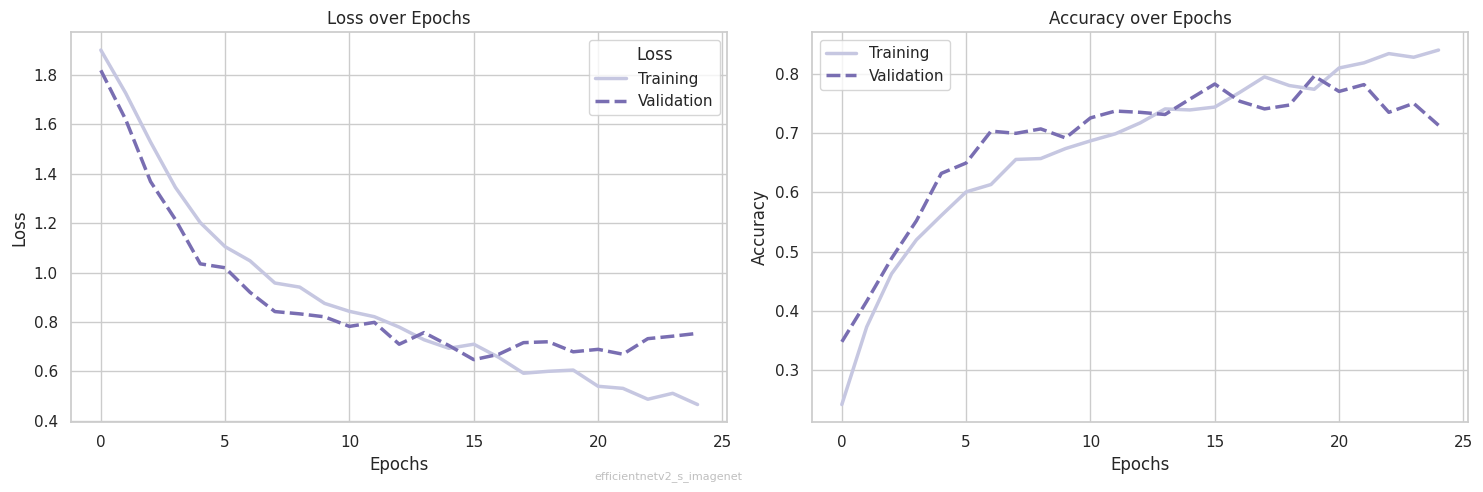

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

hist_df = pd.DataFrame(history.history)
hist_df.index = history.epoch

# Seaborn Format
sns.set_theme(style='whitegrid')
dark_palette = sns.color_palette('Purples', n_colors=2)
sns.set_palette(dark_palette)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loss
sns.lineplot(data=hist_df[['loss', 'val_loss']], linewidth=2.5, ax=axs[0])
axs[0].set_title('Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

# Custom legend
lines = axs[0].get_lines()
axs[0].legend([lines[0], lines[1]], ['Training', 'Validation'], title='Loss')

# Accuracy
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']], linewidth=2.5, ax=axs[1])
axs[1].set_title('Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

# Custom legend
lines = axs[1].get_lines()
axs[1].legend([lines[2], lines[3]], ['Training', 'Validation'])

# Model Text
plt.gcf().text(0.5, 0.02, MODEL, fontsize=8, color='gray', ha='right', va='bottom', alpha=0.5)

plt.tight_layout()
plt.savefig(f'Metrics-{MODEL}.png')
plt.show()

### 5.2 Confusion Matrix

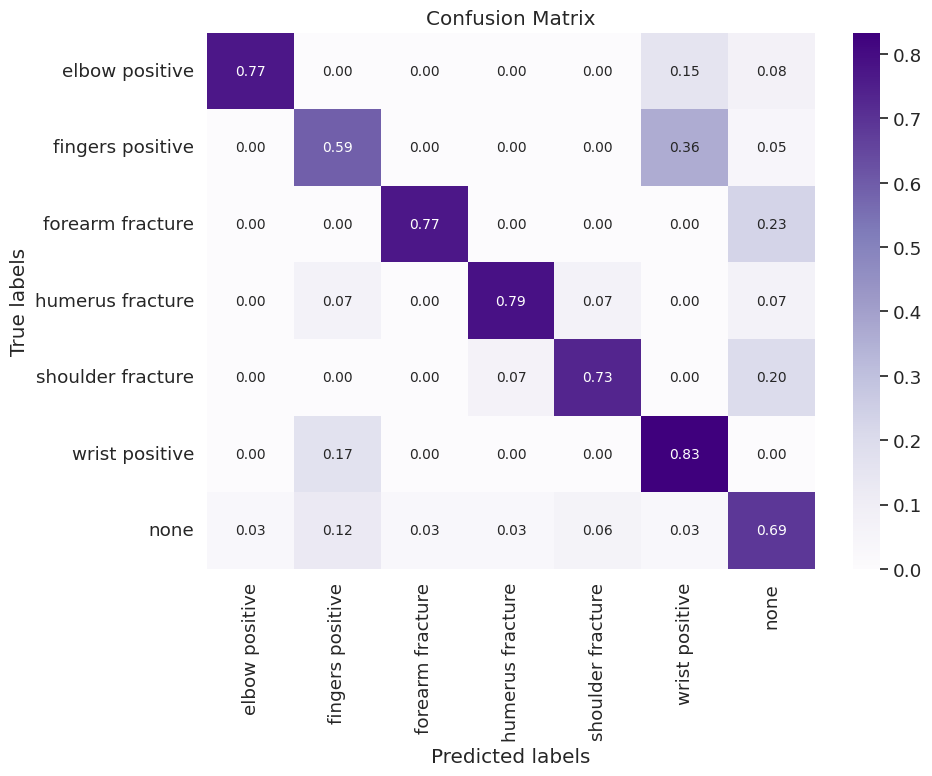

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def makeConfusionMatrix(show, tag):
    """
    Generates and optionally displays a confusion matrix heatmap for the model's predictions on the test set.
    Can also save the plot as a PNG file.

    Args:
    show (bool): If True, display the confusion matrix plot. If False, do not display.
    tag (str): Additional tag to append to the filename when saving the plot.

    Outputs:
    A confusion matrix heatmap plot, displayed and saved to a PNG file.
    """

    test_ds_eval = test_ds.unbatch().batch(1)

    # Hold True and Predicted Values
    true_labels = []
    pred_labels = []

    for img, label in test_ds_eval:
        preds = model.predict(img, verbose=0)
        pred_label = tf.argmax(preds, axis=-1).numpy()

        true_labels.append(label.numpy()[0])
        pred_labels.append(pred_label[0])

    true_labels_int = [np.argmax(label) for label in true_labels]
    cm = confusion_matrix(true_labels_int, pred_labels, normalize='true')

    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)

    sns.heatmap(cm, annot=True, annot_kws={'size': 10}, cmap='Purples', fmt='.2f', xticklabels=class_mapping.values(), yticklabels=class_mapping.values())

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    plt.tight_layout()
    plt.savefig(f'ConfusionMatrix-{MODEL}{tag}.png')
    if show:
      plt.show()

makeConfusionMatrix(True, "")

### 5.3 Visualising Predictions

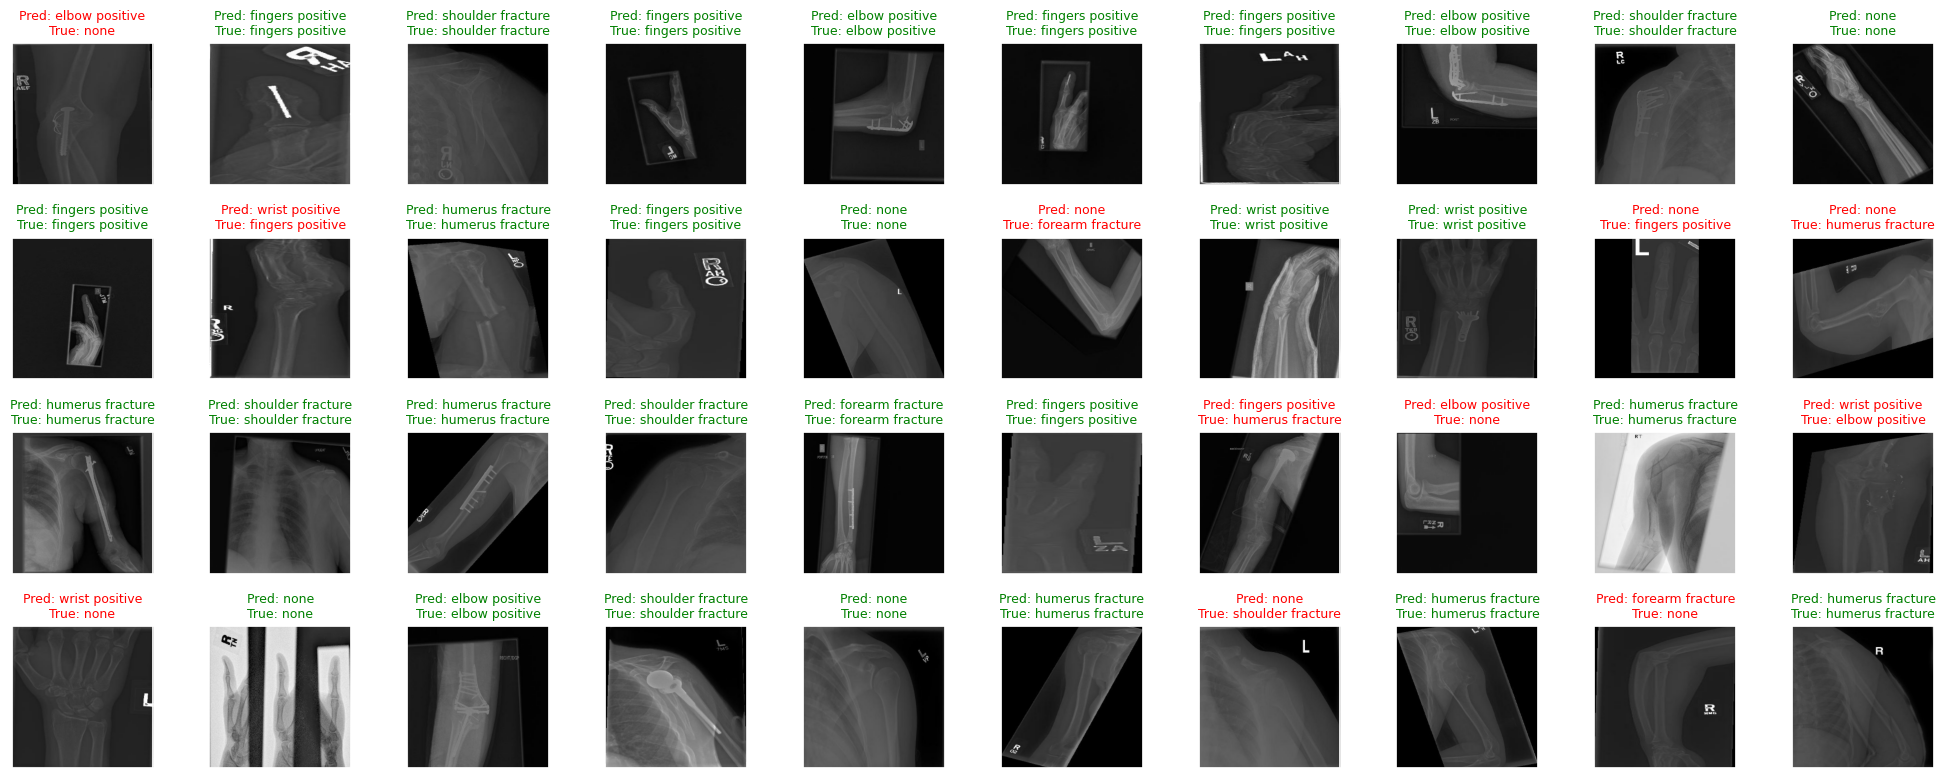

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_images_with_predictions(images, truths, predictions, class_names, rows=4, cols=10, figsize=(20, 8)):
  """
  Plot and save a grid of image samples with their prediction results.

  Args:
      images (list): List of images to be displayed.
      truths (list): Actual labels of the images.
      predictions (list): Predicted labels of the images.
      class_names (list): List of class names corresponding to label indices.
      rows (int): Number of rows in the image grid.
      cols (int): Number of columns in the image grid.
      figsize (tuple): Dimension of the figure size.

  Outputs:
      A PNG file of the plotted image grid with title annotations.
  """

  plt.figure(figsize=figsize)
  indices = np.random.choice(range(len(images)), rows * cols, replace=False)

  for i, index in enumerate(indices):
    img = images[index]

    if img.dtype == np.uint8:
      pass
    elif img.dtype == np.float32 and img.max() <= 1:
      pass
    else:
      img = img.astype('float32')
      img = img / 255.0
      img = np.clip(img, 0, 1)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    color = 'green' if predictions[index] == truths[index] else 'red'
    plt.title(f'Pred: {class_names[predictions[index]]}\nTrue: {class_names[truths[index]]}', color=color, fontsize=9)

  plt.tight_layout()
  plt.savefig(f'Predictions-{MODEL}.png')
  plt.show()



images = []
truths = []
predictions = []
class_names = list(class_mapping.values())

# Iterate over the dataset to collect images, true labels, and predictions
for img, label in test_ds.unbatch().take(100):
    # Get Image
    img_array = img.numpy()
    images.append(img_array)
    truths.append(np.argmax(label.numpy()))

    # Predict
    pred = model.predict(np.expand_dims(img_array, axis=0), verbose=0)
    pred_label = np.argmax(pred, axis=1)[0]
    predictions.append(pred_label)

plot_images_with_predictions(images, truths, predictions, class_names, rows=4, cols=10)

### 5.4 Downloading Results

In [ ]:
import zipfile
from google.colab import files

def download_results(history, plot_filenames):
    """
    Save training history and plots to a zip file and download them.

    Args:
    history (History): A Keras History object from the training process.
    plot_filenames (list of str): List of filenames for plots to include in the download.

    Outputs:
    A zip file containing the training history and plots, which is then downloaded.
    """

    results_dir = '/content/'
    os.makedirs(results_dir, exist_ok=True)

    # Save the training history
    history_path = os.path.join(results_dir, 'history.csv')
    model_path = os.path.join(results_dir,f"{MODEL}-{EPOCHS}_EPOCHS-{BATCH_SIZE}_BATCH.keras")

    pd.DataFrame(history.history).to_csv(history_path, index=False)

    # Create a zip file for all the results
    zip_path = f'/content/results-{MODEL}@{EPOCHS}.zip'

    with zipfile.ZipFile(zip_path, 'w') as zipf:
        zipf.write(history_path, arcname=os.path.basename(history_path))
        zipf.write(history_path, arcname=os.path.basename(model_path))

        for plot_filename in plot_filenames:
            plot_file_path = os.path.join(results_dir, plot_filename)
            zipf.write(plot_file_path, arcname=plot_filename)

    files.download(zip_path)

plot_filenames = [f'Predictions-{MODEL}.png', f'ConfusionMatrix-{MODEL}.png', f'Metrics-{MODEL}.png']

download_results(history, plot_filenames)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>